# Auto Encoder

オートエンコーダ

入力したものをそのまま出力するニューラルネットワーク．  
**encoder**と**decoder**の2つの部分からなる．

- encoder：入力を低次元のベクトルに変換する
- decoder：encoderの出力を元の次元に戻す

入力を一度低次元の空間に埋め込み，そこから復元するイメージ．学習が進むと，encoderの出力は入力データの特徴を捉えた**潜在変数**として扱うことが出来る．

<br>

活用例

- ノイズ削除
- 次元削減
- 異常検知

<br>

ここではノーマルなオートエンコーダを実装してみる．  
MNISTを使って、何ができるか試してみよう．

In [1]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from IPython.display import display
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')


---

## 学習

モデルを作ってみよう

In [2]:
mnist = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
dataloader = DataLoader(mnist, batch_size=64, shuffle=True)

def draw(model, n_images=10, width=800):
    """画像描画用関数"""
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(dataloader))
        x = x.view(x.size(0), -1)[:n_images].to(device)
        y = model(x)
    img = torch.cat([x, y], dim=0).view(-1, 1, 28, 28).cpu()
    img = transforms.Resize((width // n_images))(img)
    img = torchvision.utils.make_grid(img, nrow=n_images)
    img = transforms.functional.to_pil_image(img)
    display(img)

### モデル用意

encoderとdecoderを実装し，それらを組み合わせる

`z_dim`: 潜在変数の次元数

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, z_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

学習させてみよう．MSEを損失関数として使い，入力と出力の差を取る．これが小さくなるように学習させる．

In [4]:
critetion = nn.MSELoss()

def train(model, n_epochs, optimizer):
    model.train()
    for epoch in range(n_epochs):
        for x, _ in dataloader:
            optimizer.zero_grad()
            x = x.view(x.size(0), -1).to(device)
            y = model(x)
            loss = critetion(y, x)
            loss.backward()
            optimizer.step()
        print(f'{epoch+1}epoch, loss:{loss.item()}')

In [5]:
z_dim = 10
ae = AutoEncoder(z_dim).to(device)
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

5エポック学習

In [6]:
n_epochs = 5
train(ae, n_epochs, optimizer)

1epoch, loss:0.025229569524526596
2epoch, loss:0.02164585143327713
3epoch, loss:0.021535543724894524
4epoch, loss:0.016552241519093513
5epoch, loss:0.015150371938943863


結果を見てみる

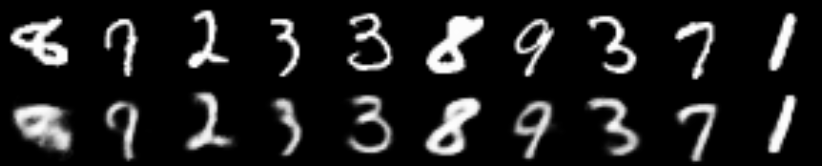

In [7]:
draw(ae)

上が入力，下が出力．  
入力をしっかりと復元できていることが分かる．

では，活用例を見てみる


---

## 次元削減

encoderは入力を低次元に圧縮しているので，そこを使えば次元削減ができる．

潜在変数の次元数を2とし，encoderを使って二次元の潜在変数をプロットする．

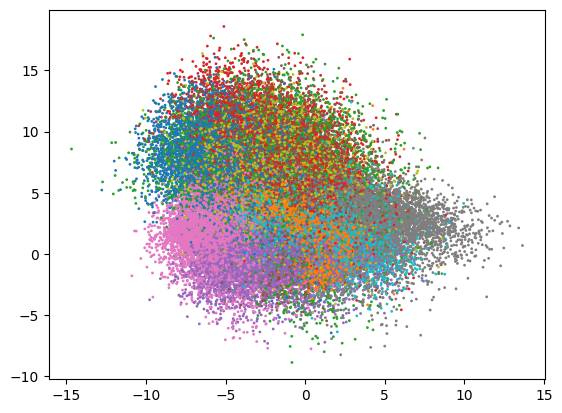

In [8]:
images = []
labels = []
ae.eval()
with torch.no_grad():
    for x, label in dataloader:
        x = x.view(x.size(0), -1).to(device)
        z = ae.encoder(x)
        images.append(z.cpu())
        labels.append(label)
images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
plt.scatter(images[:, 0], images[:, 1], c=labels, s=1, cmap='tab10');

数字ごとに特徴が表れているのが分かる

### 学習しなかった場合

学習をしていないencoderで次元削減をするとどうなるのか

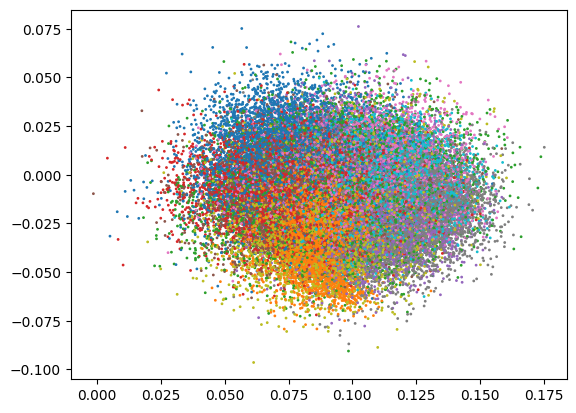

In [9]:
ae = AutoEncoder(z_dim).to(device)

images = []
labels = []
ae.eval()
with torch.no_grad():
    for x, label in dataloader:
        x = x.view(x.size(0), -1).to(device)
        z = ae.encoder(x)
        images.append(z.cpu())
        labels.append(label)
images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
plt.scatter(images[:, 0], images[:, 1], c=labels, s=1, cmap='tab10');

このように，ごちゃごちゃになる
ただよく見ると，ほんの少し色の偏りが見られると思う．全てのデータに対して同じ処理で2次元に圧縮しているため，元のデータ（入力画像）が似ていれば，2次元のベクトルも似たものになる．  

ここで，元の画像と，その白黒を反転させた画像をencoderで圧縮し，描画してみよう．

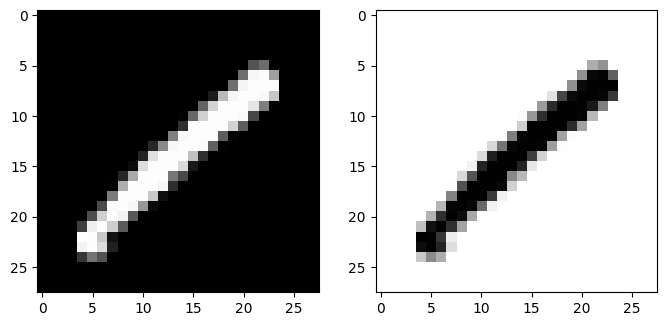

In [10]:
x = next(iter(dataloader))[0][0, 0]
reverse_x = 1 - x
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(x, cmap='gray')
axes[1].imshow(reverse_x, cmap='gray');

左が元の画像，右が反転させた画像

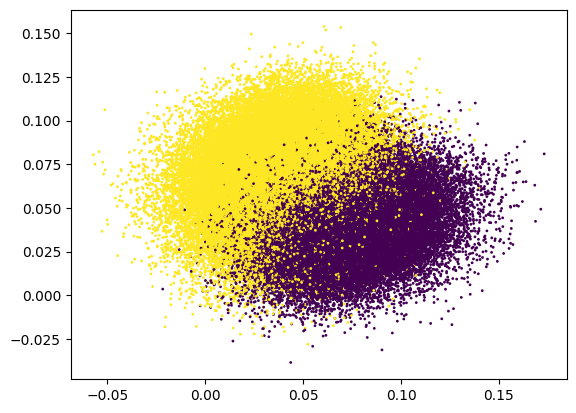

In [11]:
ae = AutoEncoder(z_dim).to(device)

images = []
labels = []
ae.eval()
with torch.no_grad():
    for x, _ in dataloader:
        x = x.view(x.size(0), -1).to(device)
        z = ae.encoder(x)
        images.append(z.cpu())
        labels.append(torch.zeros(len(z)))

        reverse_x = 1 - x
        z = ae.encoder(reverse_x)
        images.append(z.cpu())
        labels.append(torch.ones(len(z)))

images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
plt.scatter(images[:, 0], images[:, 1], c=labels, s=1);

未学習でも違いが顕著に表れた．

元の画像は黒主体の画像で，反転すると白主体の画像になる．この2種類のデータ（ベクトル）はベクトル空間$\mathbb{R}^{784}$上である程度距離が離れているため，適当な関数（未学習のencoder）で2次元空間$\mathbb{R}^2$上に写像しても距離が離れる．  
一方で，その2種類の中での**数字の違いによる$\mathbb{R}^{784}$上の距離**は先程の2種類に比べて小さいものとなるため，適当な関数で2次元空間$\mathbb{R}^2$に写像してもあまり違いが表れない．  
違いが表れるようにするには，$\mathbb{R}^{784}$の中で**対象の画像が存在する領域に着目**する必要がある．オートエンコーダを学習させることで，この領域と$\mathbb{R}^2$の対応を正確に捉えられるようになる．


---

## ノイズ削除

AEを使って低次元に圧縮することで，重要な要素を残しつつ情報量を減らせるため，ノイズ削除に使える．  
上の例にもある通り、下の方がぼやけているのが分かる。

潜在変数の次元数を減らすと、もっとぼやける

1epoch, loss:0.046368394047021866
2epoch, loss:0.04050176963210106
3epoch, loss:0.038408346474170685
4epoch, loss:0.03938138484954834
5epoch, loss:0.03666732832789421


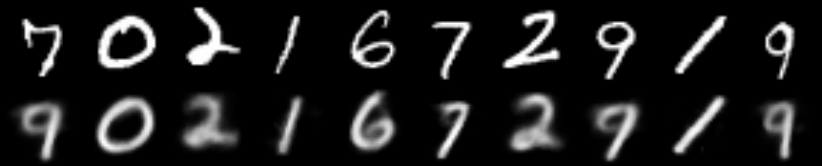

In [12]:
# 2に減らす
z_dim = 2

ae = AutoEncoder(z_dim).to(device)
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
n_epochs = 5
train(ae, n_epochs, optimizer)
draw(ae)


---

## 異常検知

入力と似た出力が行えるのは，入力が学習に使用したデータと同じ特徴を持っているときだけ．この性質を使って異常検知を行う．  
具体的な流れは以下

1. 正常なデータで学習させる
2. モデルに何らかのデータを入力する
3. モデルの出力と入力の誤差を計算する
4. 誤差が閾値を超えていたら異常と判定する

<br>

試しに，数字の0だけでモデルを学習させてみよう

In [13]:
z_dim = 10
ae = AutoEncoder(z_dim).to(device)
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
n_epochs = 5

ae.train()
for epoch in range(n_epochs):
    for x, labels in dataloader:
        if 0 not in labels:
            continue
        x = x[labels == 0] # 0だけ使用
        optimizer.zero_grad()
        x = x.view(x.size(0), -1).to(device)
        y = ae(x)
        loss = critetion(y, x)
        loss.backward()
        optimizer.step()
    print(f'{epoch+1:>3}epoch, loss:{loss.item()}')


train(ae, n_epochs, optimizer)

  1epoch, loss:0.02139388769865036
  2epoch, loss:0.022051911801099777
  3epoch, loss:0.021245121955871582
  4epoch, loss:0.022150639444589615
  5epoch, loss:0.017444156110286713
1epoch, loss:0.01984649896621704
2epoch, loss:0.017733735963702202
3epoch, loss:0.01631450653076172
4epoch, loss:0.015488793142139912
5epoch, loss:0.016080159693956375


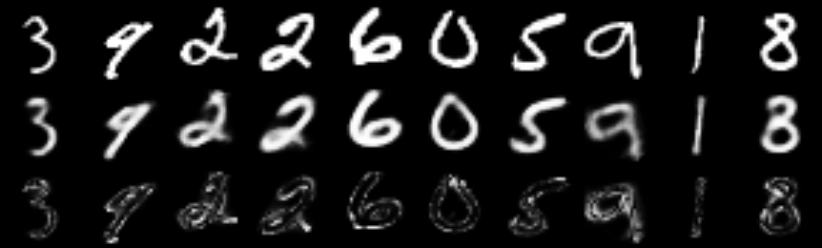

In [14]:
n_images = 10
width = 800

ae.eval()
with torch.no_grad():
    for x, labels in dataloader:
        if 0 not in labels[:n_images]:
            continue
        x = x[:n_images]
        x = x.view(x.size(0), -1).to(device)
        y = ae(x)
        break

x = x.view(n_images, 1, 28, 28).cpu()
y = y.view(n_images, 1, 28, 28).cpu()
diff = (x - y).abs()
diff = (diff - diff.min()) / (diff.max() - diff.min())
f = width // n_images
x = transforms.Resize((f))(x)
y = transforms.Resize((f))(y)
diff = transforms.Resize((f))(diff)
grid = torchvision.utils.make_grid(torch.cat([x, y, diff], dim=0), nrow=n_images)
img = transforms.functional.to_pil_image(grid)
display(img)

- 1段目：入力
- 2段目：出力
- 3段目：入力と出力の差

0以外の数値では上手く復元できていないのが分かる．というかどれも0っぽくなってしまっているね．これを見ると，入力と出力の差が大きいデータを異常と判定することができそう．

差の和を見てみる

In [15]:
print('label: diff')
for diff, label in zip(diff, labels):
    print(f'{label.item():>5}: {diff.sum().item():.3f} ')

label: diff
    3: 215.754 
    9: 326.047 
    2: 471.390 
    2: 413.044 
    6: 322.698 
    0: 288.484 
    5: 270.977 
    9: 601.449 
    1: 84.296 
    8: 407.571 


0が他と比べて小さいのが分かる


---

## データ生成

decoderを使ってデータを生成する．潜在変数が何らかの分布に従っているという仮定が必要．  
具体的な手順は以下．

- AEを学習させる
- 潜在変数が布に従っている分布を求める
- その分布から潜在変数をサンプリングする
- decoderに潜在変数を入力してデータを生成する

<br>

とりあえず学習させる

1epoch, loss:0.04776908457279205
2epoch, loss:0.047972794622182846
3epoch, loss:0.044629618525505066
4epoch, loss:0.04048439860343933
5epoch, loss:0.03930152207612991


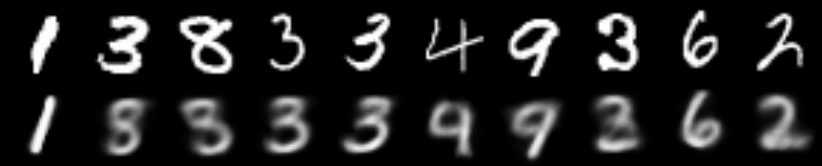

In [16]:
z_dim = 2

ae = AutoEncoder(z_dim).to(device)
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
n_epochs = 5
train(ae, n_epochs, optimizer)
draw(ae)

### 潜在変数の分布を求める

まずは観察

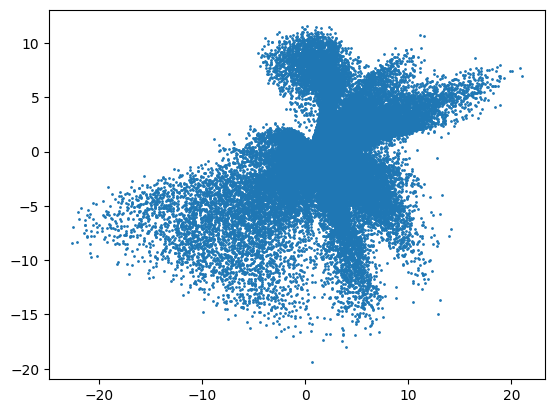

In [17]:
images = []
ae.eval()
with torch.no_grad():
    for x, label in dataloader:
        x = x.view(x.size(0), -1).to(device)
        z = ae.encoder(x)
        images.append(z.cpu())
images = torch.cat(images, dim=0)
plt.scatter(images[:, 0], images[:, 1], s=1);

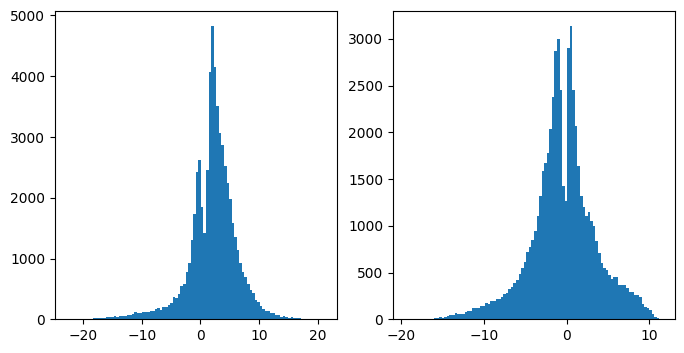

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.hist(images[:, 0], bins=100);
ax2.hist(images[:, 1], bins=100);